In [28]:
import matplotlib.pyplot as plt
import pandas as pd

from data_preparer import DataPreparer
from allocator import Allocator
import pickle

import numpy as np
from tqdm import tqdm

from igraph import Graph

In [29]:
def get_filtered_universe(preparer_obj, ts, tx, snapshot_start_id=0, snapshot_end_id=5):
    preparer_obj.prepare_snapshots(weight_combination={"ts":ts, "tx":tx})
    preparer_obj.calculate_similarity_matrix(node_count=200, snapshot_start_id=snapshot_start_id, snapshot_end_id=snapshot_end_id)
    preparer_obj.calculate_final_communes()
    node_metrics = preparer_obj.calculate_node_metrics()
    
    pagerank_threshold = np.median(node_metrics.pagerank.dropna()) - np.std(node_metrics.pagerank.dropna())*0.5 
    centrality_threshold = np.median(node_metrics.centrality.dropna())
    
    investment_universe = node_metrics.reset_index()[(node_metrics.pagerank > pagerank_threshold) & (node_metrics.centrality < centrality_threshold)]
    investment_universe = list(investment_universe.sort_values(by="centrality", ascending=True)["index"])
    
    selected_stocks = []
    for selected_id in investment_universe:
        selected_stocks.append(preparer_obj.id2stock(selected_id))
        
    return selected_stocks

In [38]:
iteration_count = 5

allocation_results = {
                      "dist_corr": {"path": "calculated_data/historical_ts_sim_distCorr.pkl"},
                      "pearson": {"path": "calculated_data/historical_ts_sim_pearson.pkl"},
                      "euclidean": {"path": "calculated_data/historical_ts_sim.pkl"}, 
                      "dtw": {"path": "calculated_data/historical_ts_sim_dtw.pkl"}
                      }

combinations = [{"id":0, "ts": 0.55, "tx": 0.45}, {"id":1, "ts": 0.0, "tx": 1.0}, {"id":2, "ts": 1.0, "tx": 0.0}]
 
preparer = DataPreparer(
        data_path="cold_data/description_vectors.pkl",
        textual_path="cold_data/textual_information.csv",
        stock2idPath="cold_data/stock2id.csv",
        stockDataPath="cold_data/stock_data.csv"
)
allocator = Allocator()
trade_start_date = "2023-05-26"

for sim_metric in list(allocation_results.keys()):    
    with open(allocation_results[sim_metric]["path"], "rb") as f:
        ts_sim = pickle.load(f)
    preparer.ts_similarities = ts_sim
    
    for combination_id, combination in enumerate(combinations):
        id, ts, tx = combination["id"], combination["ts"], combination["tx"]
        allocation_results[sim_metric][id] = []
        
        returns = []
        filtered_sizes = []
        for iteration in range(iteration_count):
            selected_stocks = get_filtered_universe(preparer, ts, tx)
            filtered_optim = allocator.mean_variance_optimization(
                preparer.stockData[(preparer.stockData.index < trade_start_date) & 
                                   (preparer.stockData.index > "2023-01-01")][selected_stocks], min_weight=0.01, take_pct_change=True
            )
            filtered_return = allocator.calculate_cumulative_return(
                filtered_optim[filtered_optim.weights > 0], 
                stockData=preparer.stockData, 
                startDate=trade_start_date
            )
            allocation_results[sim_metric][id].append(filtered_return[1])
            
            filtered_sizes.append(len(selected_stocks))
            returns.append(filtered_return[1][-1])
            
            g = Graph.Weighted_Adjacency(preparer.sim_matrix.tolist(), mode="undirected")
            path = f"saved_graphs/{sim_metric}/combination{combination_id}_{iteration}"
            g.write_edgelist(f"{path}_edgelist.txt")
            g.write(f"{path}.graphml", format="graphml")
            
        print("\nSim. Metric:", sim_metric, 
              "TS Weight:", combinations[combination_id]["ts"], "TX Weight:", combinations[combination_id]["tx"]) 
        print("Avg. Return:", np.mean(returns), "Avg. Std:", np.std(returns))
        print("Avg. Size of Filtered Universe:", np.mean(filtered_sizes))


Sim. Metric: dist_corr TS Weight: 0.55 TX Weight: 0.45
Avg. Return: 0.5827825411820278 Avg. Std: 0.025114842035714936
Avg. Size of Filtered Universe: 56.8

Sim. Metric: dist_corr TS Weight: 0.0 TX Weight: 1.0
Avg. Return: 0.5418130039769361 Avg. Std: 0.0
Avg. Size of Filtered Universe: 82.0

Sim. Metric: dist_corr TS Weight: 1.0 TX Weight: 0.0
Avg. Return: 0.37245750790813037 Avg. Std: 7.235581490417666e-05
Avg. Size of Filtered Universe: 60.6

Sim. Metric: pearson TS Weight: 0.55 TX Weight: 0.45
Avg. Return: 0.444115221953698 Avg. Std: 0.1279531156693193
Avg. Size of Filtered Universe: 48.0

Sim. Metric: pearson TS Weight: 0.0 TX Weight: 1.0
Avg. Return: 0.5418130039769361 Avg. Std: 0.0
Avg. Size of Filtered Universe: 82.0

Sim. Metric: pearson TS Weight: 1.0 TX Weight: 0.0
Avg. Return: 0.4850321850993963 Avg. Std: 0.07288775574370988
Avg. Size of Filtered Universe: 46.8

Sim. Metric: euclidean TS Weight: 0.55 TX Weight: 0.45
Avg. Return: 0.5126283077128588 Avg. Std: 0.03001518845216

In [39]:
mean_variance_optim = allocator.mean_variance_optimization(preparer.stockData[(preparer.stockData.index < trade_start_date)&(preparer.stockData.index >"2023-01-01")], 
                                                           min_weight=0.01, take_pct_change=True) 
mean_variance_return = allocator.calculate_cumulative_return(mean_variance_optim[mean_variance_optim.weights > 0], stockData=preparer.stockData, startDate=trade_start_date)

print("Return:", mean_variance_return[0])

You must convert self.cov to a positive definite matrix
Return: 0.5007765461220697


In [40]:
import datetime
import matplotlib.dates as mdates

invest_data = preparer.stockData[(preparer.stockData.index > trade_start_date)]
data_index = np.array(invest_data.index)
data_index = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in data_index]

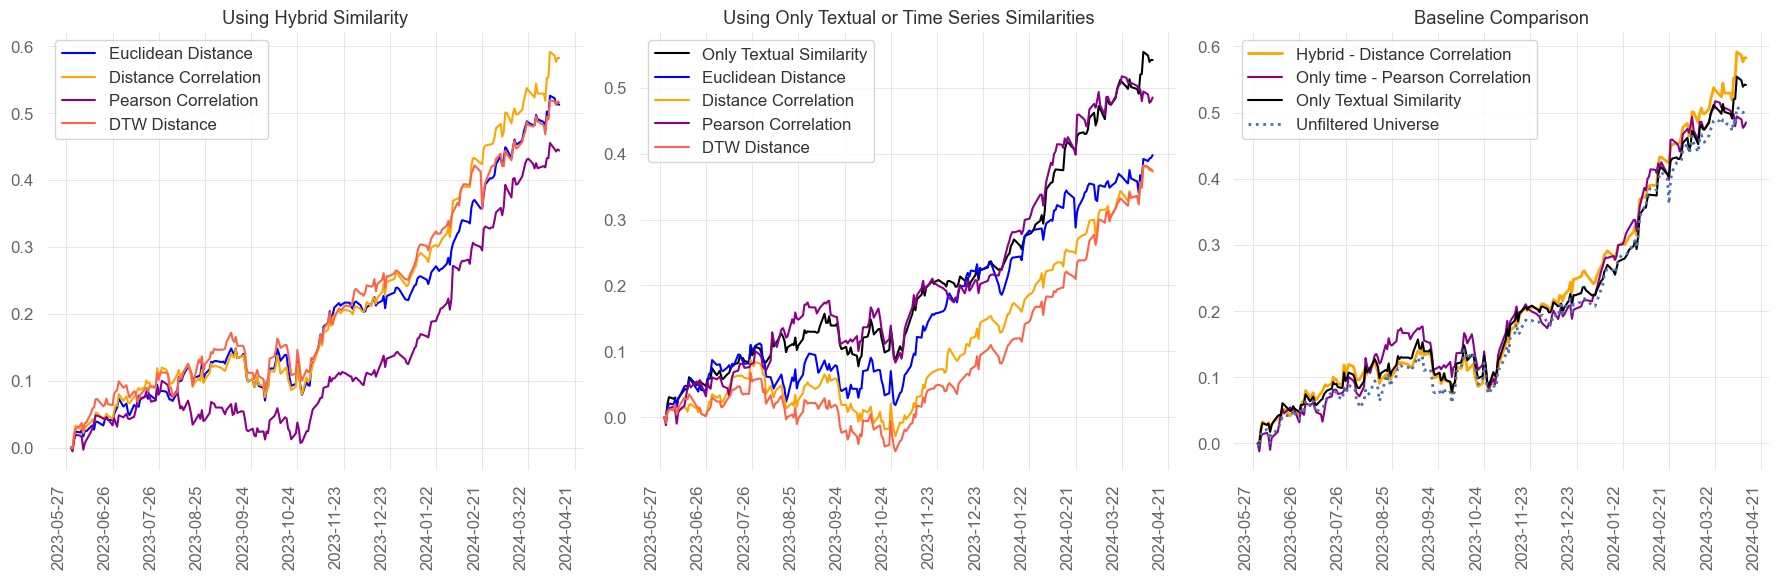

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1
axs[0].plot(pd.Series(np.mean(allocation_results["euclidean"][0], axis=0), index=data_index), label="Euclidean Distance", color="blue")
axs[0].plot(pd.Series(np.mean(allocation_results["dist_corr"][0], axis=0), index=data_index), label="Distance Correlation", color="orange")
axs[0].plot(pd.Series(np.mean(allocation_results["pearson"][0], axis=0), index=data_index), label="Pearson Correlation", color="darkmagenta")
axs[0].plot(pd.Series(np.mean(allocation_results["dtw"][0], axis=0), index=data_index), label="DTW Distance", color="tomato")
axs[0].set_title("Using Hybrid Similarity")                                                                                                                                     

axs[0].legend()

# Plot 2
axs[1].plot(data_index, pd.Series(np.mean(allocation_results["euclidean"][1], axis=0), index=data_index), label="Only Textual Similarity", color="black")
axs[1].plot(pd.Series(np.mean(allocation_results["euclidean"][2], axis=0), index=data_index), label="Euclidean Distance", color="blue")
axs[1].plot(pd.Series(np.mean(allocation_results["dist_corr"][2], axis=0), index=data_index), label="Distance Correlation", color="orange")
axs[1].plot(pd.Series(np.mean(allocation_results["pearson"][2], axis=0), index=data_index), label="Pearson Correlation", color="darkmagenta")
axs[1].plot(pd.Series(np.mean(allocation_results["dtw"][2], axis=0), index=data_index), label="DTW Distance", color="tomato")
axs[1].set_title("Using Only Textual or Time Series Similarities")
axs[1].legend()

# Plot 3
axs[2].plot(pd.Series(np.mean(allocation_results["dist_corr"][0], axis=0), index=data_index), label="Hybrid - Distance Correlation", linewidth=2, color="orange")
axs[2].plot(pd.Series(np.mean(allocation_results["pearson"][2], axis=0), index=data_index), label="Only time - Pearson Correlation", color="darkmagenta")
axs[2].plot(pd.Series(np.mean(allocation_results["euclidean"][1], axis=0), index=data_index), label="Only Textual Similarity", color="black")
axs[2].plot(pd.Series(mean_variance_return[1], index=data_index), label="Unfiltered Universe", linestyle="dotted", linewidth=2)
axs[2].legend()
axs[2].set_title("Baseline Comparison")

for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust the interval as needed
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")
    
plt.tight_layout()
plt.savefig('allocation_results_sp.png')
plt.show()

In [42]:
with open("allocation_results_sp.pkl", 'wb') as file:
    pickle.dump(allocation_results, file)